In [335]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import soundfile as sf
import queue
import boto3
import random
import json
import jams
import pandas as pd
import io
import sklearn
import scipy.io.wavfile as sciwav
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

from src.models import Segmenter1d
from src.data import load_audio, create_audio_transform, Freesound, NSynth, TUTAcousticScenes, AcousticSceneMusicSegmentation

In [486]:
class TimeCrop:
    def __init__(self, length, random=False, time_dim=-1):
        self.length = length
        self.random = random
        self.time_dim = time_dim
        
    def __call__(self, x):
        if x.shape[self.time_dim] > self.length:
            if self.random:
                start = random.randint(0, x.shape[self.time_dim] - self.length - 1)
            else:
                start = 0
            return torch.narrow(x, self.time_dim, start, self.length)
        else:
            return x

class AcousticSceneMusicSegmentation(Dataset):
    def __init__(
        self, tut_dir, nsynth_dir, split, freesound_dir=None, sample_rate=16000, n_samples=160000, random_crop=False, feature_type='mel',
        resize=None, normalize=False, standardize=False, standardize_mean=None, standardize_std=None, spec_augment=False, random_volume_reduction=False,
        shuffle_scene=False,
    ):
        self.tut_dir = tut_dir
        self.freesound_dir = freesound_dir
        self.nsynth_dir = nsynth_dir
        self.split = split
        self.sample_rate = sample_rate
        self.n_samples = n_samples
        self.random_crop = random_crop
        self.feature_type = feature_type
        self.resize = resize
        self.normalize = normalize
        self.standardize = standardize
        self.standardize_mean = standardize_mean
        self.standardize_std = standardize_std
        self.spec_augment = spec_augment
        self.random_volume_reduction = random_volume_reduction
        self.shuffle_scene = shuffle_scene
        
        tut_dataset = TUTAcousticScenes(self.tut_dir, self.split)
        nsynth_dataset = NSynth(nsynth_dir, self.split)
        
        self.scene_files = tut_dataset.meta['filename'].tolist()
        self.music_files = nsynth_dataset.files
        
        if self.freesound_dir:
            freesound_dataset = Freesound(self.freesound_dir, self.split, binary=True)
            music_meta = freesound_dataset.meta[freesound_dataset.meta['label'] == 'instrument'].reset_index(drop=True)
            self.music_files += music_meta['fname'].tolist()
        
        self.transform = create_audio_transform(
            self.sample_rate,
            n_samples=self.n_samples,
            random_crop=False,
            feature_type=self.feature_type,
            resize=self.resize,
            normalize=self.normalize,
            standardize=self.standardize,
            standardize_mean=self.standardize_mean,
            standardize_std=self.standardize_std,
            spec_augment=self.spec_augment
        )
        
    def __len__(self):
        return len(self.scene_files)

    def __getitem__(self, idx):
        scene_fname = self.scene_files[idx]
        music_fname = random.choice(self.music_files)
        
        audio, start, end = self.combine_audio(scene_fname, music_fname, random_volume_reduction=self.random_volume_reduction)
        features = self.transform(audio)
        
        # create segmentation mask
        scale = (features.shape[-1] / audio.shape[-1])
        start = int(scale*start)
        end = int(scale*end)
        mask = torch.zeros(features.shape[-1], device=features.device, dtype=torch.float32)
        mask[start:end] = 1.0
        
        return features, mask
    
    def _shuffle_audio(self, audio, n_parts=4):
        splits = np.split(audio, sorted(random.sample(range(audio.shape[1]), n_parts-1)), axis=1)
        random.shuffle(splits)
        audio = torch.cat(splits, dim=1)
        return audio
    
    def combine_audio(self, scene_fname, music_fname, random_volume_reduction=False):
        scene = load_audio(scene_fname, sample_rate=self.sample_rate)
        music = load_audio(music_fname, sample_rate=self.sample_rate)
        
        # convert to mono
        scene = scene.mean(0, keepdim=True)
        music = music.mean(0, keepdim=True)
        
        # apply random crop just to scene
        if self.random_crop:
            scene = TimeCrop(self.n_samples, random=True)(scene)
            
        # shuffle scene
        if self.shuffle_scene:
            scene = self._shuffle_audio(scene, n_parts=4)
        
        # trim leading/trailing zeros from music audio
        music = torch.from_numpy(np.trim_zeros(music.squeeze().numpy())).unsqueeze(0)
        
        # truncate music audio if longer than scene audio
        if music.shape[-1] > (scene.shape[-1] - self.sample_rate*2):
            music = music[..., :scene.shape[-1] - self.sample_rate*2]
            
        # normalize music volume to match scene volume
        if random_volume_reduction:
            scene_to_music_ratio = random.random()*3 + 1.0
        else:
            scene_to_music_ratio = 1.0

        new_max = scene.max() / scene_to_music_ratio
        new_min = scene.min() / scene_to_music_ratio
        music = (((music - music.min()) * (new_max - new_min)) / (music.max() - music.min())) + new_min
        
        # insert music into scene
        start = random.randint(0, scene.shape[-1] - music.shape[-1] - 1)
        end = start+music.shape[-1]
        scene[..., start:end] = np.clip(scene[..., start:end] + music, scene.min(), scene.max())
        
        return scene, start, end

In [487]:
dataset = AcousticSceneMusicSegmentation(
    'data/DCASE2018/Task1', 'data/nsynth', 'train', freesound_dir='data/freesound', normalize=True, standardize=True, 
    standardize_mean=0.4299, standardize_std=0.1770, spec_augment='freq', random_volume_reduction=True, random_crop=True,
    shuffle_scene=True
)

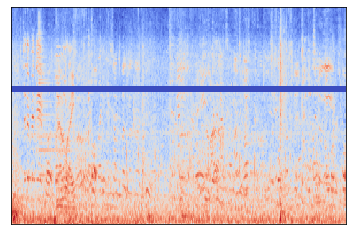

In [497]:
features, mask = dataset[2]
librosa.display.specshow(features.numpy().squeeze(), sr=16000)

In [474]:
audio = load_audio(dataset.scene_files[10])

In [475]:
IPython.display.Audio(audio, rate=16000)

In [476]:
splits = np.split(audio, sorted(random.sample(range(audio.shape[1]), 3)), axis=1)
random.shuffle(splits)
audio = torch.cat(splits, dim=1)

In [481]:
IPython.display.Audio(audio, rate=16000)

In [455]:
sorted(random.sample(range(10), 3))

[1, 6, 7]

In [426]:
np.split(np.array(list(range(10)))[None, ...], [3, 5], axis=1)

[array([[0, 1, 2]]), array([[3, 4]]), array([[5, 6, 7, 8, 9]])]

In [398]:
np.array(list(range(10)))[None, ...].shape

(1, 10)

In [9]:
audio, _, _ = combine_audio(dataset.scene_files[10], dataset.music_files[2], random_volume_reduction=True)

In [10]:
IPython.display.Audio(audio, rate=16000)

In [31]:
IPython.display.Audio(audio, rate=16000)

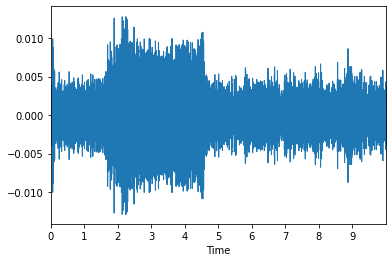

In [14]:
librosa.display.waveplot(audio.numpy().squeeze(), sr=16000)

In [15]:
len(dataset.scene_files)

8639

In [252]:
class MusicVsNoise(Dataset):
    def __init__(self, nsynth_dir, tut_scenes_dir, split, sample_rate=16000, n_samples=64000, random_crop=False, feature_type='mel', resize=None,
                 normalize=False, standardize=False, standardize_mean=None, standardize_std=None, spec_augment=False):
        self.nsynth_dir = nsynth_dir
        self.tut_scenes_dir = tut_scenes_dir
        self.split = split
        self.sample_rate = sample_rate
        self.n_samples = n_samples
        self.random_crop = random_crop
        self.feature_type = feature_type
        self.resize = resize
        self.normalize = normalize
        self.standardize = standardize
        self.standardize_mean = standardize_mean
        self.standardize_std = standardize_std
        self.spec_augment = spec_augment
        
        if resize and type(resize) != tuple:
            raise Exception('resize must be tuple')
            
        nsynth_dataset = NSynth(self.nsynth_dir, self.split)
        tut_dataset = TUTAcousticScenes(self.tut_scenes_dir, self.split)
        
        self.music_files = nsynth_dataset.files
        self.noise_files = tut_dataset.meta['filename'].tolist()
        
        self.meta = pd.DataFrame()
        self.meta['filename'] = self.music_files + self.noise_files
        self.meta['label'] = ['music']*len(self.music_files) + ['noise']*len(self.noise_files)
        self.meta = self.meta.sample(frac=1).reset_index(drop=True)
        
        self.transform = create_audio_transform(
            self.sample_rate,
            n_samples=self.n_samples,
            random_crop=self.random_crop,
            feature_type=self.feature_type,
            resize=self.resize,
            normalize=self.normalize,
            standardize=self.standardize,
            standardize_mean=self.standardize_mean,
            standardize_std=self.standardize_std,
            spec_augment=self.spec_augment
        )
        
    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        wav_fname = self.meta.iloc[idx]['filename']
        features = self.extract_features(wav_fname)
        
        return features, self.meta.iloc[idx]['label']
        
    def extract_features(self, wav_fname):
        audio = load_audio(wav_fname, sample_rate=self.sample_rate)
    
        features = self.transform(audio)
        return features

In [297]:
dataset = MusicVsNoise('data/nsynth', 'data/DCASE2018/Task1', 'train', random_crop=True, normalize=True)

In [264]:
dataset[102]

(tensor([[[ -5.6074,  -7.8622, -11.2715,  ..., -14.0968, -17.0410, -14.1433],
          [ -5.4439,  -8.8025, -13.6820,  ..., -11.1737, -16.2057, -20.0985],
          [ -7.6047, -13.3580, -14.0392,  ...,  -8.8404, -12.0042, -12.0827],
          ...,
          [-63.6225, -64.2919, -66.6790,  ..., -65.8120, -61.6992, -60.8389],
          [-66.3811, -66.1979, -66.6627,  ..., -65.9420, -63.7820, -61.6141],
          [-69.6632, -65.5468, -64.4833,  ..., -63.2073, -62.8419, -62.7627]]]),
 'noise')

In [291]:
dataset[2][0]

tensor([[[  22.1917,   19.1247,    8.3408,  ..., -100.0000, -100.0000,
          -100.0000],
         [  27.0479,   22.5741,    5.5379,  ..., -100.0000, -100.0000,
          -100.0000],
         [  28.3537,   23.1969,    2.4018,  ..., -100.0000, -100.0000,
          -100.0000],
         ...,
         [ -20.8660,  -26.3548,  -49.5300,  ..., -100.0000, -100.0000,
          -100.0000],
         [ -25.8383,  -30.8350,  -48.0247,  ..., -100.0000, -100.0000,
          -100.0000],
         [ -45.8091,  -50.9249,  -59.9639,  ..., -100.0000, -100.0000,
          -100.0000]]])

In [324]:
dataset[409]

(tensor([[[0.8676, 0.8582, 0.8191,  ..., 0.6340, 0.6366, 0.6866],
          [0.9133, 0.9173, 0.9266,  ..., 0.6448, 0.6804, 0.7244],
          [0.8744, 0.8694, 0.9217,  ..., 0.7191, 0.7067, 0.6817],
          ...,
          [0.2085, 0.1859, 0.1740,  ..., 0.1568, 0.1341, 0.1527],
          [0.1742, 0.1627, 0.1419,  ..., 0.1637, 0.1260, 0.1261],
          [0.1906, 0.1735, 0.1518,  ..., 0.1507, 0.1095, 0.0957]]]), 'noise')

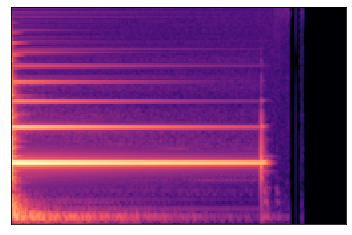

In [334]:
librosa.display.specshow(dataset[0][0].numpy().squeeze(), sr=16000)

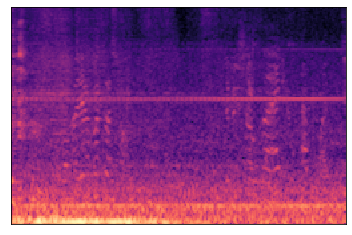

In [330]:
librosa.display.specshow(dataset[409][0].numpy().squeeze(), sr=16000)